---
title: "Homework 4: ACS Income Prediction"
format:
  html:
    embed-resources: true
execute:
  python: env/bin/python3.11
number-sections: false

__Name:__ \<Benjamin Salvo\>
---

This homework assignment guides you through building and evaluating machine learning models to predict individual income using the American Community Survey (ACS) microdata. You will implement both an XGBoost model and a fully connected neural network using Keras, following the workflows demonstrated in the provided tutorials. The focus will be on log-transforming the income target, feature engineering, model training, and evaluation.

## Setup

### Data
Use the ACS microdata file `usa_00005.dta` that I shared on Populi. This dataset contains individual-level records with demographic and socioeconomic features, including total personal income (`inctot`).


## Task 1: Load and Log-transform ACS Data

Following the final attempt in the XGBoost tutorial, sample 10% of the microdata, drop any rows where `inctot == 9999999`.

In [1]:
#In the previous prep data they encoded categorical variables

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

data = pd.read_stata("../data/raw/usa_00005.dta")

# subset to 10% of the data
data = data.sample(frac=0.1, random_state=42).reset_index(drop=True)
missing_val = 9999999
data = data[data['inctot'] != missing_val]

#Checking if the dataframe dropped the missing values
count = (data['inctot'] == missing_val).sum() 
print(count)

0


__Question 1:__ Why is it not necessary to impute or filter our missing values for other features?

Because XGBoost has a built-in fuction to deal with missing values. In the case of Neural Nets, we have to convert all inputs to numeric. In this training models, the most important thing is to drop NaNs values from the output (income or log-income) which we did.

### Task 1.1: Log-transform Income

Instead of predicting income directly, we will predict log-income.
Create a new target column `log_inctot` by applying the natural log transformation to `inctot` after adding 1 (i.e., `np.log1p`).
Filter out any rows where `inctot` is less than or equal to zero before applying the log transformation.
Make a histogram of both the original income and log-income distributions to visualize the effect of the transformation.

In [2]:

#Acknowledge how many values of inctot are less or equal to zero

count_zero = (data['inctot'] <= 0).sum()
print(count_zero)

#Dropping any rows where inctot is less than or equal to zero.

data_drop = data[data['inctot'] > 0]

#Creating a new column applying the natural log transformation to inctot
data_drop['log_inctot'] = np.log1p(data_drop['inctot'])

#Creating the target column

y1 = data_drop['log_inctot']
y2 = data['inctot']

# all other variables are features
X = data_drop.drop(columns=['log_inctot','inctot'])

35410


C:\Users\bsalvo\AppData\Local\Temp\ipykernel_20648\3815279029.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_drop['log_inctot'] = np.log1p(data_drop['inctot'])


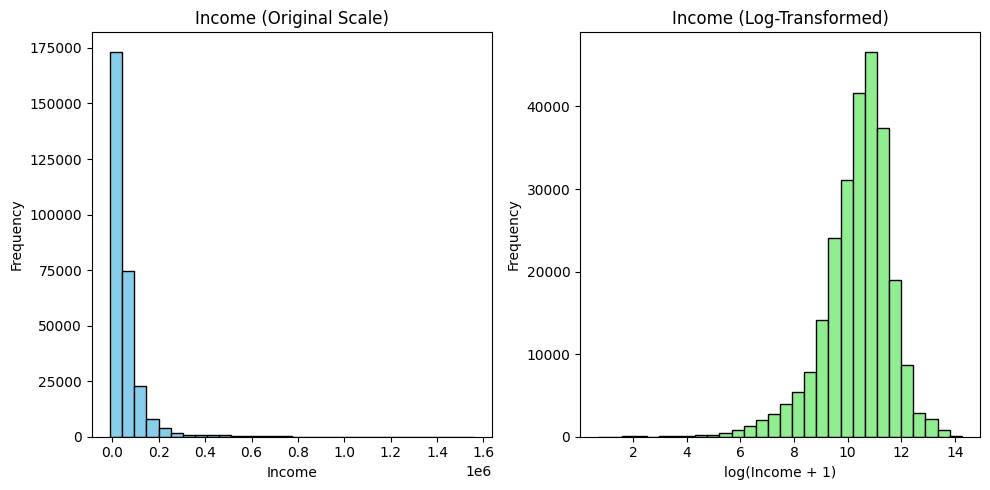

In [3]:
# Plot histograms
plt.figure(figsize=(10, 5))

# Histogram 
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.hist(y2, bins=30, color='skyblue', edgecolor='black')
plt.title('Income (Original Scale)')
plt.xlabel('Income')
plt.ylabel('Frequency')

# Histogram after log
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.hist(y1, bins=30, color='lightgreen', edgecolor='black')
plt.title('Income (Log-Transformed)')
plt.xlabel('log(Income + 1)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

__Question 2:__ What are the advantages of predicting log-income rather than income directly?

Reduce the skewness that we can see in the plot on the left, producing distributions more symmetric. 
Also stabilize the variance from extreme outliers.
And in the more practical side, when you have log income we could interpret the results as percentage changes. 


## Task 2: Feature Engineering and Encoding
Split the data into a feature matrix `X` and target vector `y` (the log-income column created above). Perform one-hot encoding on all categorical features, dropping sparse columns whose proportion of non-zero entries falls below 1%.
The feature matrix `X` should include all columns except `inctot` and `log_inctot`.
The target vector `y` should be the `log_inctot` column.
Mimic the one-hot encoding workflow from the tutorial: build dummies for every categorical column in `X`, then drop sparse columns whose proportion of non-zero entries falls below 1%.

In [4]:
print(X.shape)

# one hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=False)
print(X_encoded.shape)

# get rid of columns with almost all 0's
cols_to_keep = [col for col in X_encoded.columns if (X_encoded[col] != 0).mean() > 0.01]
X_encoded = X_encoded[cols_to_keep]

print(X_encoded.shape)

(253800, 143)
(253800, 11054)
(253800, 695)


### Task 2.1: Train/Test Split
Split the encoded data into training and testing sets (80/20).

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y1, test_size=0.2, random_state=42)

## Task 3: XGBoost Modeling (Log Target)
Reproduce the final modeling attempt from `examples/XGBoost.ipynb`, but treat the log-income target as the label. Work through the following subtasks and insert your own code in each block.

### Task 3.1: Build DMatrix Objects
Create `xgb.DMatrix` objects for both the training and test splits using the log-income labels.

In [6]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

### Task 3.2: Hyperparameter Dictionary
Start from the tutorial’s baseline settings (e.g., `eta = 1`, `max_depth = 10`, `min_child_weight = 100`, RMSE metric, early stopping after 50 rounds) and justify any deviations you make.
Use the `reg:squarederror` objective and `rmse` evaluation metric.

In [8]:
params = {
    'eta': 1,
    'max_depth': 10,
    'min_child_weight': 100,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'verbosity': 2
}

evallist = [(dtrain, 'train'), (dtest, 'eval')]
num_round = 10000
early_stopping_rounds = 50

### Train the model

In [9]:
bst = xgb.train(params,
                dtrain,
                num_round,
                evallist,
                early_stopping_rounds=early_stopping_rounds)

c:\Intro-to-ML-2025\.venv-1\Lib\site-packages\xgboost\core.py:771: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-rmse:0.86602	eval-rmse:0.87989
[1]	train-rmse:0.84843	eval-rmse:0.86629
[2]	train-rmse:0.83715	eval-rmse:0.86015
[3]	train-rmse:0.82764	eval-rmse:0.85640
[4]	train-rmse:0.82206	eval-rmse:0.85503
[5]	train-rmse:0.81635	eval-rmse:0.85662
[6]	train-rmse:0.81298	eval-rmse:0.85707
[7]	train-rmse:0.80724	eval-rmse:0.85769
[8]	train-rmse:0.80288	eval-rmse:0.85770
[9]	train-rmse:0.80038	eval-rmse:0.85782
[10]	train-rmse:0.79769	eval-rmse:0.85856
[11]	train-rmse:0.79434	eval-rmse:0.85998
[12]	train-rmse:0.79013	eval-rmse:0.86082
[13]	train-rmse:0.78839	eval-rmse:0.86178
[14]	train-rmse:0.78579	eval-rmse:0.86248
[15]	train-rmse:0.78339	eval-rmse:0.86421
[16]	train-rmse:0.78001	eval-rmse:0.86572
[17]	train-rmse:0.77791	eval-rmse:0.86714
[18]	train-rmse:0.77453	eval-rmse:0.86865
[19]	train-rmse:0.77293	eval-rmse:0.86902
[20]	train-rmse:0.76949	eval-rmse:0.86977
[21]	train-rmse:0.76676	eval-rmse:0.87057
[22]	train-rmse:0.76434	eval-rmse:0.87186
[23]	train-rmse:0.76214	eval-rmse:0.87357
[2

### Visualize the results

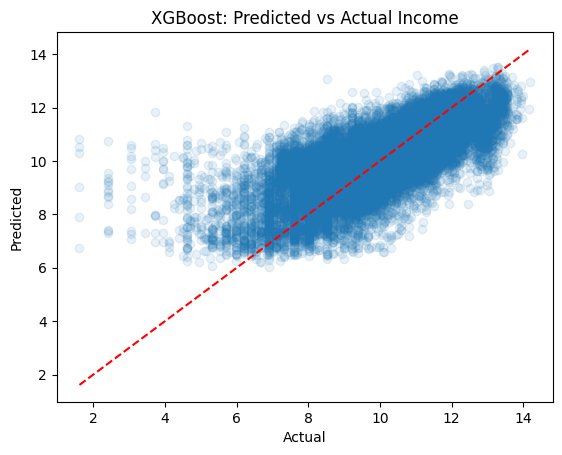

In [10]:
y_pred_plt = bst.predict(dtest, iteration_range=(0, bst.best_iteration + 1))
y_test_plt = y_test

# y_plt_pred = np.log(y_pred)
# y_plt_test = np.log(y_test)

plt.scatter(y_test_plt, y_pred_plt, alpha=0.1)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("XGBoost: Predicted vs Actual Income")
plt.plot([y_test_plt.min(), y_test_plt.max()], [y_test_plt.min(), y_test_plt.max()], 'r--')  # diagonal line
plt.show()


### Task 3.3: Hyperparameter Tuning

Perform a grid search over the `eta = [1, 0.1, 0.01]` and `max_depth = [3, 6, 10]` parameters to identify the best combination based on validation RMSE (i.e., for each combination of `eta` and `max_depth`, train a model and record the validation RMSE).
Use early stopping with a patience of 50 rounds and a maximum of 10,000 training rounds.

Training with eta=1, max_depth=3
[0]	train-rmse:1.00554	eval-rmse:1.00502
[1]	train-rmse:0.96701	eval-rmse:0.96831
[2]	train-rmse:0.94986	eval-rmse:0.95139
[3]	train-rmse:0.93508	eval-rmse:0.93599
[4]	train-rmse:0.92262	eval-rmse:0.92398
[5]	train-rmse:0.91506	eval-rmse:0.91698
[6]	train-rmse:0.90780	eval-rmse:0.90983
[7]	train-rmse:0.90208	eval-rmse:0.90466
[8]	train-rmse:0.89864	eval-rmse:0.90161
[9]	train-rmse:0.89418	eval-rmse:0.89695
[10]	train-rmse:0.89103	eval-rmse:0.89493
[11]	train-rmse:0.88781	eval-rmse:0.89108
[12]	train-rmse:0.88286	eval-rmse:0.88600
[13]	train-rmse:0.87996	eval-rmse:0.88330
[14]	train-rmse:0.87769	eval-rmse:0.88091
[15]	train-rmse:0.87372	eval-rmse:0.87726
[16]	train-rmse:0.87190	eval-rmse:0.87573
[17]	train-rmse:0.87063	eval-rmse:0.87466
[18]	train-rmse:0.86911	eval-rmse:0.87327
[19]	train-rmse:0.86681	eval-rmse:0.87078
[20]	train-rmse:0.85754	eval-rmse:0.86316
[21]	train-rmse:0.85575	eval-rmse:0.86121
[22]	train-rmse:0.85485	eval-rmse:0.86068
[23]	train-

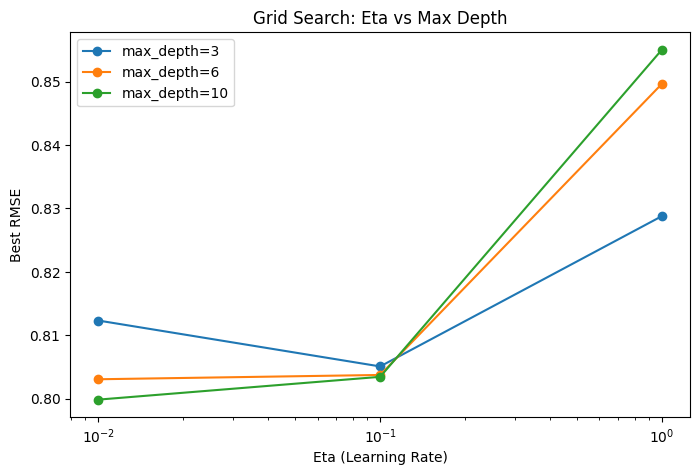

In [11]:
etas = [1, 0.1, 0.01]
depths = [3, 6, 10]

models = {}
scores = {}

num_round = 10000
early_stopping_rounds = 50

evallist = [(dtrain, 'train'), (dtest, 'eval')]

for eta in etas:
    for max_depth in depths: 
        params = {
            'eta': eta,
            'max_depth': max_depth,
            'min_child_weight': 100,
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 1
        }

        print(f"Training with eta={eta}, max_depth={max_depth}")

        bst = xgb.train(params,
                        dtrain,
                        num_round,
                        evallist,
                        early_stopping_rounds=early_stopping_rounds)

        models[(eta, max_depth)] = bst
        scores[(eta, max_depth)] = bst.best_score

# Find best combination
best_params = min(scores, key=scores.get)
print("\n✅ Best Parameters:")
print(f"  eta = {best_params[0]}")
print(f"  max_depth = {best_params[1]}")
print(f"  Best RMSE = {scores[best_params]}")

# Plot results
plt.figure(figsize=(8,5))
for max_depth in depths:
    plt.plot(
        etas,
        [scores[(eta, max_depth)] for eta in etas],
        marker='o',
        label=f'max_depth={max_depth}'
    )

plt.xscale('log')
plt.xlabel('Eta (Learning Rate)')
plt.ylabel('Best RMSE')
plt.title('Grid Search: Eta vs Max Depth')
plt.legend()
plt.show()

__Question 3:__ Which hyperparameter combination yielded the lowest validation RMSE, and what was that RMSE value?
Based on the results, do you think you need to expand the grid search other values or parameters?
(Note: You do not need to actually search for more parameters, just discuss.)

The hyperparameter combination which yielded the lowest validation RMSE is eta = 0.01 and max_depth = 10, with an RMSE value of 0.799864.
Based on the results, I don't think it will be helpful to expand the grid search because in the case with eta = 0.01, the gain from max_depth 3 to max_depth 10 is not huge, so I don't think we can see a lot better RMSE values with different hyperparameters.  

### Task 3.4: Final Model Training
Using the best hyperparameters from Task 3.3, train a final XGBoost model on the full dataset.

In [12]:
#Setting the DMatrix for the full dataset
dfull = xgb.DMatrix(X_encoded, label=y1)

params = {
    'eta': 0.01,
    'max_depth': 10,
    'min_child_weight': 100,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'verbosity': 2
}

evallist = [(dfull, 'full')]
num_round = 10000
early_stopping_rounds = 50

bst = xgb.train(params,
                dfull,
                num_round,
                evallist,
                early_stopping_rounds=early_stopping_rounds)

c:\Intro-to-ML-2025\.venv-1\Lib\site-packages\xgboost\core.py:771: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	full-rmse:1.27001
[1]	full-rmse:1.26326
[2]	full-rmse:1.25661
[3]	full-rmse:1.25006
[4]	full-rmse:1.24360
[5]	full-rmse:1.23723
[6]	full-rmse:1.23096
[7]	full-rmse:1.22476
[8]	full-rmse:1.21868
[9]	full-rmse:1.21268
[10]	full-rmse:1.20676
[11]	full-rmse:1.20092
[12]	full-rmse:1.19518
[13]	full-rmse:1.18951
[14]	full-rmse:1.18393
[15]	full-rmse:1.17843
[16]	full-rmse:1.17302
[17]	full-rmse:1.16762
[18]	full-rmse:1.16231
[19]	full-rmse:1.15711
[20]	full-rmse:1.15195
[21]	full-rmse:1.14689
[22]	full-rmse:1.14190
[23]	full-rmse:1.13700
[24]	full-rmse:1.13210
[25]	full-rmse:1.12733
[26]	full-rmse:1.12255
[27]	full-rmse:1.11788
[28]	full-rmse:1.11326
[29]	full-rmse:1.10877
[30]	full-rmse:1.10429
[31]	full-rmse:1.09985
[32]	full-rmse:1.09551
[33]	full-rmse:1.09126
[34]	full-rmse:1.08704
[35]	full-rmse:1.08286
[36]	full-rmse:1.07877
[37]	full-rmse:1.07478
[38]	full-rmse:1.07081
[39]	full-rmse:1.06689
[40]	full-rmse:1.06302
[41]	full-rmse:1.05927
[42]	full-rmse:1.05553
[43]	full-rmse:1.0518

### Task 3.5: Evaluate Predictions
Plot predicted vs. actual log-income values on the test set using a scatter plot.

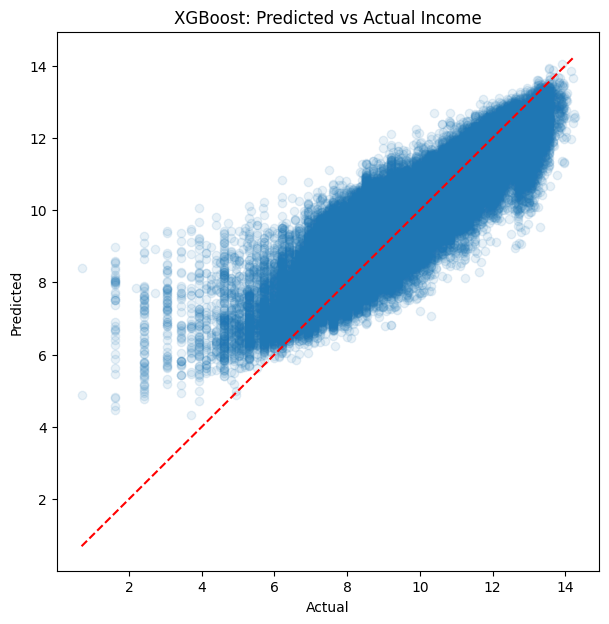

In [13]:
y_pred_plt = bst.predict(dfull, iteration_range=(0, bst.best_iteration + 1))
y_plt = y1

plt.figure(figsize=(7,7))
plt.scatter(y_plt, y_pred_plt, alpha=0.1)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("XGBoost: Predicted vs Actual Income")
plt.plot([y_plt.min(), y_plt.max()], [y_plt.min(), y_plt.max()], 'r--')  # diagonal line
plt.show()

__Question 4:__ Qualitatively, how well do the predictions align with the actual values?

The predictions align with the actual values very well with larger log-income values. For the lower values, the difference between the actual and the predicted values are larger.

## Task 4: Neural Network Modeling (Keras)
Use the structure from `examples/neural_nets_simple.ipynb` to fit a fully connected neural network on the same encoded features and log-income target.
Use the same train/test split as in Task 2.1.

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random

### Task 4.1: Prepare Data for Keras
If necessary, convert the training and test feature matrices and target vectors into NumPy arrays suitable for Keras.
__Note:__ You may have already done this in Task 2.1.

In [15]:
print(X.shape)

#Define the categorical columns
categorical_cols = X.select_dtypes(exclude=['number']).columns.tolist()
print("Categorical columns:", categorical_cols)

# one hot encode categorical variables
X_encoded_nn = pd.get_dummies(X, drop_first=True)
print(X_encoded_nn.shape)

# get rid of columns with almost all 0's
cols_to_keep = [col for col in X_encoded_nn.columns if (X_encoded_nn[col] != 0).mean() > 0.01]
X_encoded_nn = X_encoded_nn[cols_to_keep]

# get rid of columns that were not encoded
dummy_cols = [c for c in X_encoded_nn.columns if any(c.startswith(col + "_") for col in categorical_cols)]
X_encoded_nn = X_encoded_nn[dummy_cols]

print(X_encoded_nn)

print(X_encoded_nn.shape)

(253800, 143)
Categorical columns: ['year', 'sample', 'statefip', 'metro', 'gq', 'farm', 'ownershp', 'ownershpd', 'mortgage', 'mortgag2', 'acrehous', 'mortamt1', 'mortamt2', 'taxincl', 'insincl', 'propinsr', 'proptx99', 'rent', 'rentgrs', 'condofee', 'foodstmp', 'valueh', 'fridge', 'sink', 'stove', 'rooms', 'plumbing', 'hotwater', 'shower', 'builtyr2', 'unitsstr', 'bedrooms', 'phone', 'cinethh', 'cilaptop', 'cismrtphn', 'citablet', 'ciothcomp', 'cidatapln', 'cihispeed', 'cisat', 'cidial', 'ciothsvc', 'fuelheat', 'vehicles', 'coupletype', 'ssmc', 'nfams', 'nsubfam', 'ncouples', 'nmothers', 'nfathers', 'multgen', 'multgend', 'cbnsubfam', 'famunit', 'famsize', 'nchild', 'nchlt5', 'nsibs', 'sex', 'age', 'marst', 'marrno', 'marrinyr', 'yrmarr', 'divinyr', 'widinyr', 'fertyr', 'race', 'raced', 'hispan', 'hispand', 'bpl', 'bpld', 'citizen', 'yrnatur', 'yrimmig', 'yrsusa1', 'hcovany', 'hcovpriv', 'hinsemp', 'hinspur', 'hinstri', 'hcovpub', 'hinscaid', 'hinscare', 'hinsva', 'hinsihs', 'school',

In [19]:
#Splitting again the entire dataset into train and test

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_encoded_nn, y1, test_size=0.2, random_state=666)  

X_train_nn = X_train_nn.to_numpy(dtype = "float32")
X_test_nn = X_test_nn.to_numpy(dtype = "float32")
y_train_nn = y_train_nn.to_numpy(dtype = "float32") 
y_test_nn = y_test_nn.to_numpy(dtype = "float32")


### Task 4.2: Define the Architecture
Implement a dense network with several ReLU-activated hidden layers (e.g., 256-128-64) and compile it with the Adam optimizer and MSE loss.

__Question 5:__ What should the input dimension be for the first layer of the network be?

The input dimension need to be the number of columns or variables in the dataset (X). In this case, we drop several columns before, so the number of variables is lower compared to the XGBoost model.

In [20]:
#Define the Neural Network

nn_model = keras.Sequential([
    layers.Dense(256, activation="relu", input_shape=(568,)),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)

])

nn_model.compile(optimizer='adam', loss='mse')

c:\Intro-to-ML-2025\.venv-1\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Task 4.3: Initial Training
Fit the model on the training data while validating on the test set.
Run the training for a maximum of 1,000 epochs.
I have some example code below that includes early stopping to prevent overfitting.
You may adjust as needed.
The `patience` parameter in the `EarlyStopping` callback controls how many epochs with no improvement on the validation loss to wait before stopping training.
The `batch_size` is a parameter that we haven't discussed in class, but it limits the amount of data the model is exposed to at once during training.
You can leave it at 1024 for this assignment.

In [21]:
 history = nn_model.fit(
     X_train_nn,
     y_train_nn,
     validation_data=(X_test_nn, y_test_nn),
     epochs=1000,
     batch_size=1024,
     verbose=1,
     callbacks=[
         keras.callbacks.EarlyStopping(
             monitor="val_loss",
             patience=10,
             restore_best_weights=True,
         )
     ],
 )


Epoch 1/1000
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.1826 - val_loss: 0.7802
Epoch 2/1000
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7687 - val_loss: 0.7533
Epoch 3/1000
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7489 - val_loss: 0.7397
Epoch 4/1000
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7319 - val_loss: 0.7271
Epoch 5/1000
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7174 - val_loss: 0.7359
Epoch 6/1000
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7060 - val_loss: 0.7159
Epoch 7/1000
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6948 - val_loss: 0.7127
Epoch 8/1000
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6828 - val_loss: 0.7222
Epoch 9/1000
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6737 - val_loss: 0.7087
Epoch 10/1000
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6583 - val_loss: 0.7207
Epoch 11/1000
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6451 - val_loss: 0.7234
Epoch 12/1000
199/199 ━━━━━━━━

#### Task 4.3a
Plot the training and validation loss curves over epochs.

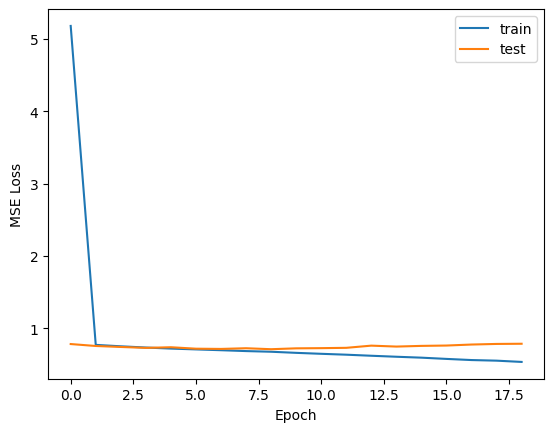

In [22]:
# plot the loss curves
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

__Question 6:__ Based on the loss curves, does the model appear to be underfitting, overfitting, or well-fitted? Justify your answer.

It seems that the model is overfitting because there is a huge gap at the begin between the train and test lines and at the end, those values converges to a similar val loss.

### Task 4.4: Model Tuning
The neural network architecture and training parameters can significantly impact performance.
The architecture consists of the number of layers, layer dimensions, and activation functions.
Create three different architectures: the one from Task 4.2, a deeper/wider one, and a shallower/narrower one.
Additionally, consider three different learning rates: `1e-3`, `1e-4`, and `1e-5`.
Perform a grid search over these architectures and learning rates to identify the best combination based on validation loss.
__Hint:__ Save the models and their histories in a dictionary for easy comparison later.

In [23]:
#Defining a model that builds a model    
def build_nn_model(n_layers=[256, 128, 64], learning_rate=1e-3):
    """Create and compile a feed‑forward network with given layer sizes."""
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train_nn.shape[1],)))

    # Add hidden layers from the list
    for units in n_layers:
        model.add(layers.Dense(units, activation="relu"))

    # Output layer for regression
    model.add(layers.Dense(1))

    # Compile
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mse")   # or 'mae', etc.

    return model

In [24]:
#Defining architecture and learning rates
architectures = {
    "shallow": [64, 32],
    "medium": [256, 128, 64],
    "deep": [512, 256, 128, 64]
}

learning_rates = [1e-3, 1e-4, 1e-5]

In [25]:
results = {}

for arch_name, arch_layers in architectures.items():
    for lr in learning_rates:
        model_name = f"{arch_name}_lr{lr}"
        print(f"Training {model_name}")

        model = build_nn_model(n_layers=arch_layers, learning_rate=lr)

        # Train with early stopping
        history = model.fit(
            X_train_nn, y_train_nn,
            validation_data=(X_test_nn, y_test_nn),
            epochs=1000,
            batch_size=512,
            verbose=0,   # silence training output
            callbacks=[keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=20, restore_best_weights=True)
            ]
        )

        # Save model and history
        results[model_name] = {
            "model": model,
            "history": history.history,
            "val_loss_min": min(history.history["val_loss"])
        }

        print(f"{model_name} → min val_loss: {results[model_name]['val_loss_min']:.4f}")

Training shallow_lr0.001
shallow_lr0.001 → min val_loss: 0.7070
Training shallow_lr0.0001
shallow_lr0.0001 → min val_loss: 0.7080
Training shallow_lr1e-05
shallow_lr1e-05 → min val_loss: 0.7019
Training medium_lr0.001
medium_lr0.001 → min val_loss: 0.7189
Training medium_lr0.0001
medium_lr0.0001 → min val_loss: 0.7120
Training medium_lr1e-05
medium_lr1e-05 → min val_loss: 0.7066
Training deep_lr0.001
deep_lr0.001 → min val_loss: 0.7159
Training deep_lr0.0001
deep_lr0.0001 → min val_loss: 0.7096
Training deep_lr1e-05
deep_lr1e-05 → min val_loss: 0.7099


In [26]:
#Compare results    

best_model = min(results.items(), key=lambda x: x[1]["val_loss_min"])
print("Best model:", best_model[0], "val_loss:", best_model[1]["val_loss_min"])

Best model: shallow_lr1e-05 val_loss: 0.7019235491752625


__Question 7:__ Which architecture and learning rate combination yielded the lowest validation loss, and what was that loss value?

The best architecture was shallow with a learning rate of 1e-05. Combined resulted in a 0.7091 validation loss, the lowest between all the scenarios.

### Task 4.5: Evaluate Predictions
Generate predictions on the test set using the best model from Task 4.
Create a scatter plot of predicted vs. actual log-income values.

In [27]:
#Best model

best_model_obj = keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=(568,)),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)

])

best_model_obj.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='mse'
)

history = best_model_obj.fit(
     X_train_nn,
     y_train_nn,
     validation_data=(X_test_nn, y_test_nn),
     epochs=1000,
     batch_size=1024,
     verbose=1,
     callbacks=[
         keras.callbacks.EarlyStopping(
             monitor="val_loss",
             patience=10,
             restore_best_weights=True,
         )
     ],
 )


Epoch 1/1000
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 110.5493 - val_loss: 105.9736
Epoch 2/1000
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 100.2952 - val_loss: 94.6008
Epoch 3/1000
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 87.8081 - val_loss: 81.1938
Epoch 4/1000
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 74.1757 - val_loss: 67.4469
Epoch 5/1000
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 60.5383 - val_loss: 53.9414
Epoch 6/1000
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 47.4982 - val_loss: 41.4535
Epoch 7/1000
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35.8361 - val_loss: 30.6331
Epoch 8/1000
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.9963 - val_loss: 21.7502
Epoch 9/1000
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.1354 - val_loss: 14.8671
Epoch 10/1000
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.2256 - val_loss: 9.8720
Epoch 11/1000
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0873 - val_loss: 6.5171
Epoch 12

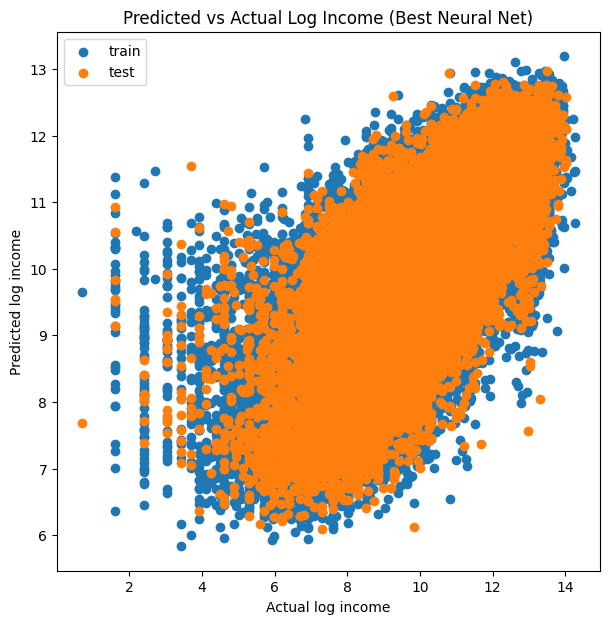

In [28]:
y_test_pred_nn = best_model_obj.predict(X_test_nn, verbose=0)
y_test_pred_nn = y_test_pred_nn.ravel()

y_train_pred_nn = best_model_obj.predict(X_train_nn, verbose=0)
y_train_pred_nn = y_train_pred_nn.ravel()

plt.figure(figsize=(7,7))
plt.scatter(y_train_nn, y_train_pred_nn, label = "train")
plt.scatter(y_test_nn, y_test_pred_nn, label = "test" )
plt.xlabel("Actual log income")
plt.ylabel("Predicted log income")
plt.title("Predicted vs Actual Log Income (Best Neural Net)")
plt.legend()
plt.show()


## Task 5: Model Comparison and Reflection
Which model would you choose for predicting log-income on new ACS data: the XGBoost model from Task 3 or the neural network from Task 4? Why?

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

metrics = {
    "NN": {
        "MSE": mean_squared_error(y_test_nn, y_test_pred_nn),
        "RMSE": np.sqrt(mean_squared_error(y_test_nn, y_test_pred_nn)),
        "MAE": mean_absolute_error(y_test_nn, y_test_pred_nn),
        "R2": r2_score(y_test_nn, y_test_pred_nn)
    },
    "XGB": {
        "MSE": mean_squared_error(y1, y_pred_plt),
        "RMSE": np.sqrt(mean_squared_error(y1, y_pred_plt)),
        "MAE": mean_absolute_error(y1, y_pred_plt),
        "R2": r2_score(y1, y_pred_plt)
    }
}

print(metrics)

{'NN': {'MSE': 0.7017629146575928, 'RMSE': np.float64(0.8377129070615975), 'MAE': 0.5817466974258423, 'R2': 0.5695593357086182}, 'XGB': {'MSE': 0.3375898118967128, 'RMSE': np.float64(0.5810247945627732), 'MAE': 0.39388618691526905, 'R2': 0.7929340973222926}}


The best model is XGB because it performs better in all the metrics: lower MSE, RMSE and MAE and higher R2. One of the reasons of this is that in order to perform the Neural Net model, we have to drop several variables of the dataset in comparison of XGBoost.